In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# not required for visualization
!pip install torch==1.0.0 torchvision==0.2.2 -f https://download.pytorch.org/whl/cu90/torch_stable.html
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu100/torch_nightly.html

In [ ]:
# mignt not be required for visualization
import os
# get personal flownet2-pytorch source
!git clone https://32beed5a62f268dd48707a0ad14aee4b5cb061ac@github.com/ryannggy/fn-colab.git
!mv /content/fn-colab /content/flownet2pytorch
os.chdir('./flownet2pytorch')

In [ ]:
# install custom layers, not required for visualization
!bash install.sh

In [ ]:
# not required for visualization
import os
os.sys.path.append('/root/.local/lib/python3.6/site-packages/resample2d_cuda-0.0.0-py3.6-linux-x86_64.egg')
os.sys.path.append('/root/.local/lib/python3.6/site-packages/correlation_cuda-0.0.0-py3.6-linux-x86_64.egg')
os.sys.path.append( '/root/.local/lib/python3.6/site-packages/channelnorm_cuda-0.0.0-py3.6-linux-x86_64.egg')

In [ ]:
# not required for visualization (maybe)
!pip install pypng
!pip install tensorboardx
!pip install setproctitle colorama scipy==1.1.0

In [ ]:
!pip install scipy==1.4.1
os.chdir('/content/flownet2pytorch')

Define Viewing Methods

In [13]:
# Source:https://github.com/sampepose/flownet2-tf/blob/master/src/flowlib.py
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors

UNKNOWN_FLOW_THRESH = 1e7
def show_flow(filename):
    """
    visualize optical flow map using matplotlib
    :param filename: optical flow file
    :return: None
    """
    flow = read_flow(filename)
    #print(flow)
    img = flow_to_image(flow)
    plt.imshow(img)
    plt.show()

def read_flow(filename):
    """
    read optical flow from Middlebury .flo file
    :param filename: name of the flow file
    :return: optical flow data in matrix
    """
    f = open(filename, 'rb')
    magic = np.fromfile(f, np.float32, count=1)
    data2d = None

    if 202021.25 != magic:
        print ('Magic number incorrect. Invalid .flo file')
    else:
        w = int(np.fromfile(f, np.int32, count=1)[0])
        h = int(np.fromfile(f, np.int32, count=1)[0])
        #print("Reading %d x %d flo file" % (h, w))
        data2d = np.fromfile(f, np.float32, count=2 * w * h)
        # reshape data into 3D array (columns, rows, channels)
        data2d = np.resize(data2d, (h, w, 2))
    f.close()
    
    print(data2d)
    print(data2d.shape)
    
    return data2d

def flow_to_image(flow):
    """
    Convert flow into middlebury color code image
    :param flow: optical flow map
    :return: optical flow image in middlebury color
    """
    u = flow[:, :, 0]
    v = flow[:, :, 1]

    maxu = -999.
    maxv = -999.
    minu = 999.
    minv = 999.

    idxUnknow = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknow] = 0
    v[idxUnknow] = 0

    maxu = max(maxu, np.max(u))
    minu = min(minu, np.min(u))

    maxv = max(maxv, np.max(v))
    minv = min(minv, np.min(v))

    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(-1, np.max(rad))

    #print( "max flow: %.4f\nflow range:\nu = %.3f .. %.3f\nv = %.3f .. %.3f" % (maxrad, minu,maxu, minv, maxv))

    u = u/(maxrad + np.finfo(float).eps)
    v = v/(maxrad + np.finfo(float).eps)

    img = compute_color(u, v)

    idx = np.repeat(idxUnknow[:, :, np.newaxis], 3, axis=2)
    img[idx] = 0

    return np.uint8(img)


def compute_color(u, v):
    """
    compute optical flow color map
    :param u: optical flow horizontal map
    :param v: optical flow vertical map
    :return: optical flow in color code
    """
    [h, w] = u.shape
    img = np.zeros([h, w, 3])
    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    colorwheel = make_color_wheel()
    ncols = np.size(colorwheel, 0)

    rad = np.arctan2(v, u)
    rad += np.pi
    rad /= 2*np.pi

    a = np.sqrt(v**2 + u**2)
    a = normalized_all_sig(a, fn='mag')

    fk = (a+1) / 2 * (ncols - 1) + 1

    k0 = np.floor(fk).astype(int)

    k1 = k0 + 1
    k1[k1 == ncols+1] = 1
    f = fk - k0

    for i in range(0, np.size(colorwheel,1)):
        tmp = colorwheel[:, i]
        col0 = tmp[k0-1] / 255
        col1 = tmp[k1-1] / 255
        col = (1-f) * col0 + f * col1

        idx = rad <= 1
        col[idx] = 1-rad[idx]*(1-col[idx])
        notidx = np.logical_not(idx)

        col[notidx] *= 0.75
        img[:, :, i] = np.uint8(np.floor(255 * col*(1-nanIdx)))

    return img


def make_color_wheel():
    """
    Generate color wheel according Middlebury color code
    :return: Color wheel
    """
    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR
    colorwheel = np.zeros([ncols, 3])
    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.transpose(
        np.floor(255 * np.arange(0, RY) / RY))
    col += RY

    # YG
    colorwheel[col:col + YG, 0] = 255 - \
        np.transpose(np.floor(255 * np.arange(0, YG) / YG))
    colorwheel[col:col + YG, 1] = 255
    col += YG

    # GC
    colorwheel[col:col + GC, 1] = 255
    colorwheel[col:col + GC,
                2] = np.transpose(np.floor(255 * np.arange(0, GC) / GC))
    col += GC

    # CB
    colorwheel[col:col + CB, 1] = 255 - \
        np.transpose(np.floor(255 * np.arange(0, CB) / CB))
    colorwheel[col:col + CB, 2] = 255
    col += CB

    # BM
    colorwheel[col:col + BM, 2] = 255
    colorwheel[col:col + BM,
                0] = np.transpose(np.floor(255 * np.arange(0, BM) / BM))
    col += + BM

    # MR
    colorwheel[col:col + MR, 2] = 255 - \
        np.transpose(np.floor(255 * np.arange(0, MR) / MR))
    colorwheel[col:col + MR, 0] = 255

    return colorwheel


def normalized_all_sig(sig, fn=None):
    if fn == "angle":
        sig = np.asarray(sig)
        abs_sig = abs(sig)
        # print('sig type', type(sig))

        e_max, e_min = np.max(abs_sig), np.min(abs_sig)
        # print('e_max {}, e_min {}'.format(e_max, e_min))

        abs_sig_normalized = []
        for abs_sig_tmp in abs_sig:
            abs_sig_normalized_tmp = (abs_sig_tmp - e_min) * (2*np.pi) / (e_max-e_min)
            abs_sig_normalized.append(abs_sig_normalized_tmp)

        abs_sig_normalized = np.asarray(abs_sig_normalized)
        abs_sig_normalized -= np.pi

        return abs_sig_normalized

    if fn == 'mag':
        sig = np.asarray(sig)
        abs_sig = abs(sig)
        e_max, e_min = np.max(abs_sig), np.min(abs_sig)
        abs_sig_normalized = []
        for abs_sig_tmp in abs_sig:
            abs_sig_normalized_tmp = (abs_sig_tmp - e_min) / (e_max-e_min)
            abs_sig_normalized.append(abs_sig_normalized_tmp)

        abs_sig_normalized = np.asarray(abs_sig_normalized)
        return abs_sig_normalized


    sig = np.asarray(sig)
    abs_sig = abs(sig)
    abs_sig[abs_sig > 1.0] = 1.0
    e_max, e_min = np.max(abs_sig), np.min(abs_sig)
    abs_sig_normalized = []
    for abs_sig_tmp in abs_sig:
        abs_sig_normalized_tmp = (abs_sig_tmp - e_min) / (e_max-e_min)
        abs_sig_normalized.append(abs_sig_normalized_tmp)

    abs_sig_normalized = np.asarray(abs_sig_normalized)
    return abs_sig_normalized

[[[ 675.38763 -339.5534 ]
  [ 671.9117  -337.34952]
  [ 668.58923 -335.21826]
  ...
  [ 711.43243 -354.94632]
  [ 722.3758  -360.62665]
  [ 733.3437  -366.32904]]

 [[ 664.6245  -334.1748 ]
  [ 661.04553 -331.91592]
  [ 657.6201  -329.72952]
  ...
  [ 702.7894  -350.46033]
  [ 714.0239  -356.29   ]
  [ 725.26855 -362.13504]]

 [[ 653.82294 -328.7842 ]
  [ 650.1354  -326.46765]
  [ 646.601   -324.2232 ]
  ...
  [ 694.35785 -346.07666]
  [ 705.88715 -352.05798]
  [ 717.41095 -358.04745]]

 ...

 [[ 511.3144  -253.82509]
  [ 504.06052 -249.90282]
  [ 496.58212 -245.9117 ]
  ...
  [ 473.04443 -231.0815 ]
  [ 483.16428 -236.2923 ]
  [ 493.44208 -241.6083 ]]

 [[ 510.39703 -254.77432]
  [ 502.97656 -250.81734]
  [ 495.3382  -246.79462]
  ...
  [ 479.01044 -234.942  ]
  [ 488.927   -240.03485]
  [ 499.00226 -245.23225]]

 [[ 509.69095 -255.81068]
  [ 502.12073 -251.8243 ]
  [ 494.33936 -247.7753 ]
  ...
  [ 484.92813 -238.78273]
  [ 494.65878 -243.76627]
  [ 504.54767 -248.85329]]]
(100, 100,

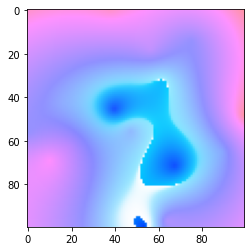

In [14]:
#put file path to your flow file here
#show_flow('/content/drive/MyDrive/inference_output/inference/run.epoch-0-flow-field/000000.flo')
show_flow('frame_0001.flo')